In [1]:
from IPython.display import display, Markdown
import datetime
today = datetime.date.today()
display(Markdown('## COVID-19 en España. Datos tomados de https://covid19.isciii.es'))
display(Markdown('#### Consultado el ' + today.strftime("%d/%m/%Y")))

## COVID-19 en España. Datos tomados de https://covid19.isciii.es

#### Consultado el 26/04/2020

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import io
import base64
import requests
from scipy.optimize import curve_fit
from scipy.special import erf
from IPython.display import HTML

In [3]:
warnings.filterwarnings('ignore')

In [4]:
#https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally

class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 0px;
        border: 0px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))

In [5]:
region = {
    'ES': 'Total España',
    'AN': 'Andalucía',
    'AR': 'Aragón',
    'AS': 'Principado de Asturias',
    'CB': 'Cantabria',
    'CE': 'Ceuta',
    'CL': 'Castilla y León',
    'CM': 'Castilla-La Mancha',
    'CN': 'Canarias',
    'CT': 'Cataluña',
    'EX': 'Extremadura',
    'GA': 'Galicia',
    'IB': 'Islas Baleares',
    'RI': 'La Rioja',
    'MD': 'Comunidad de Madrid',
    'MC': 'Región de Murcia',
    'ML': 'Melilla',
    'NC': 'Comunidad Foral de Navarra',
    'PV': 'País Vasco',
    'VC': 'Comunidad Valenciana',
}

In [6]:
#Download data from official source

url="https://covid19.isciii.es/resources/serie_historica_acumulados.csv"
csvdoc=requests.get(url).content
df=pd.read_csv(io.StringIO(csvdoc.decode('ISO-8859-1')), error_bad_lines=False)

df = df[df['CCAA'].isin([*region])] #Take only the rows with a valid region - eliminate trailing comments

In [7]:
#This dataset is a mess and its format changes every other day :-(
# now, when CASOS = 0, we fill that column with sum of 'PCR+' + 'TestAc+'

df.fillna(0, inplace=True)
df.loc[(df['CASOS']==0), 'CASOS'] = df['PCR+'] + df['TestAc+']

In [8]:
df.tail()

,CCAA,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados
1249,ML,25/4/2020,121.0,110.0,11.0,44.0,3.0,2.0,81.0
1250,MC,25/4/2020,1771.0,1474.0,297.0,627.0,106.0,127.0,920.0
1251,NC,25/4/2020,5452.0,4712.0,740.0,1942.0,129.0,431.0,1835.0
1252,PV,25/4/2020,14315.0,12455.0,1860.0,6426.0,533.0,1230.0,9602.0
1253,RI,25/4/2020,4998.0,3861.0,1137.0,1380.0,84.0,315.0,2037.0


In [9]:
df.describe()

,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000
mean,4111.444179,1369.804625,97.531898,1733.939394,180.524721,390.921053,1325.012759
std,9067.176566,6398.337904,399.785739,3605.915871,382.098036,1066.445638,4135.903041
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,666.000000,0.000000,0.000000,233.500000,33.000000,18.000000,20.000000
75%,3466.500000,0.000000,0.000000,1575.500000,144.750000,235.500000,734.500000
max,62817.000000,59126.000000,3691.000000,25665.000000,2583.000000,7922.000000,35367.000000


In [10]:
#Skew normal
def skew_normal(x, sigmag, mu, alpha,a):
    c = 0
    #normal distribution
    normpdf = (1/(sigmag*np.sqrt(2*np.pi)))*np.exp(-(np.power((x-mu),2)/(2*np.power(sigmag,2))))
    normcdf = (0.5*(1+erf((alpha*((x-mu)/sigmag))/(np.sqrt(2)))))
    return 2*a*normpdf*normcdf + c

In [11]:
def plotGraph(df, codigo2digitos, columnName, colorName, oPlot, size='normal', dif=False):
    df.FECHA=pd.to_datetime(df.FECHA, format='%d/%m/%Y')
    df = df.groupby('FECHA')[columnName].sum().to_frame()
    df=df.sort_values(by='FECHA')
    df['Index'] = range(1, len(df) + 1)
    df=df.set_index('Index')
    if dif:
        graphColumn='Dif'
        df['Dif'] = df[columnName] - df[columnName].shift(1)
        df.fillna(0, inplace=True)
        df.drop(columnName, axis=1, inplace=True)
    else:
        graphColumn=columnName
    yData=df[df[graphColumn].cumsum().gt(0)].to_numpy()
    yData=yData.reshape(yData.size)
    xData=np.arange(yData.size)
    xFit = np.arange(0.0, yData.size+5, 1)
    plt.style.use('seaborn-white')
    if size=='big':
        fig, ax = plt.subplots(1, 1, figsize=(12,8))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))

    ax.bar(xData, yData, align='center', color=colorName, alpha=0.8)
    try:
        popt, pcov = curve_fit(skew_normal, xData, yData, p0=(np.argmax(yData),np.argmax(yData),1,np.max(yData)*yData.size/2))
        ax.title.set_text(columnName+' - '+region[codigo2digitos])
        ax.plot(xFit, skew_normal(xFit, *popt), 'r')
    except:
        ax.title.set_text(region[codigo2digitos] + " - NO CONVERGE")
        ax.plot(xFit, (lambda x: np.zeros(x.size))(xFit), 'r')
    finally:
        oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
        plt.close() # this gets rid of the plot so it doesn't appear in the cell

In [12]:
def plotAll(df, column, color, dif=False):
    oPlot = FlowLayout()
    df.fillna(0, inplace=True)
    plotGraph(df, 'ES', column, color, oPlot, size='big', dif=dif)
    for comunidad, df_aux in df.groupby('CCAA'):
        plotGraph(df_aux, comunidad, column, color, oPlot, dif=dif)
    oPlot.PassHtmlToCell()


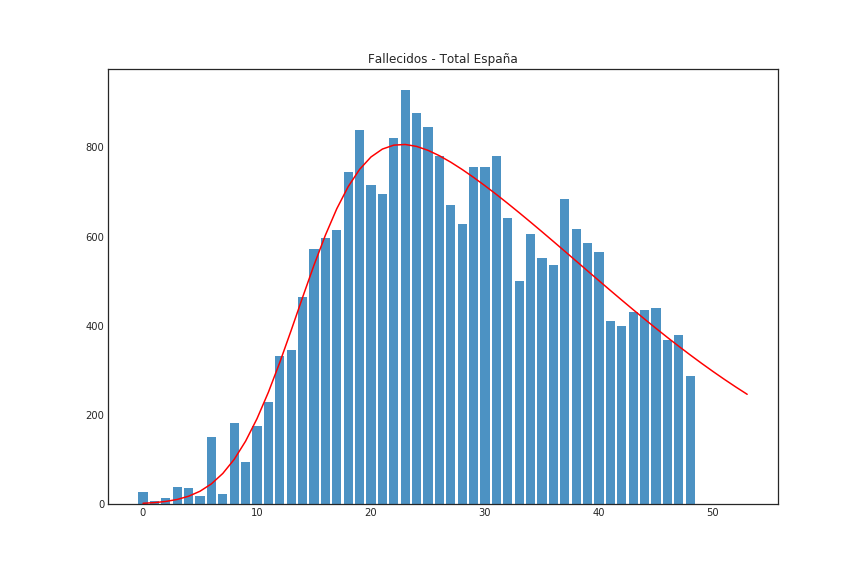
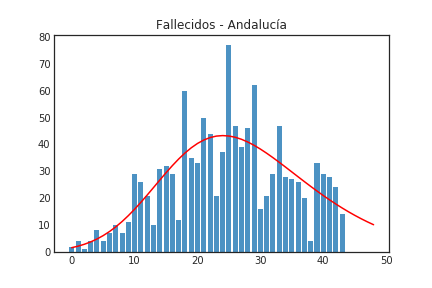
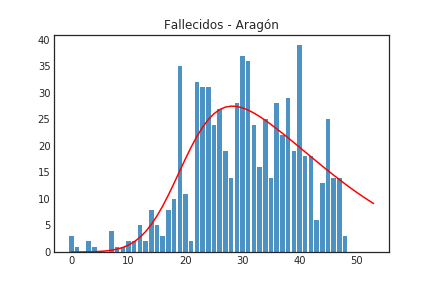
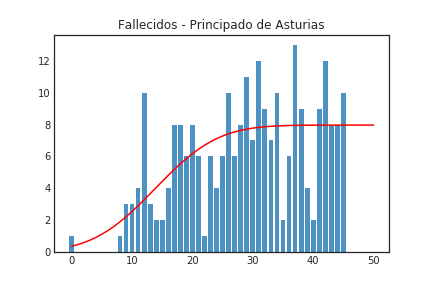
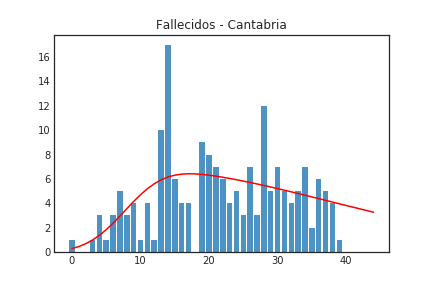
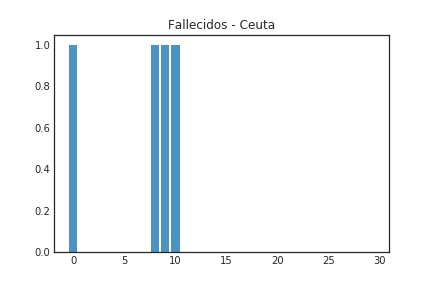
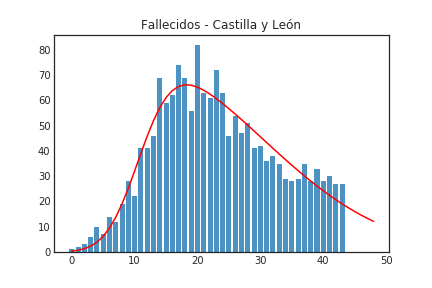
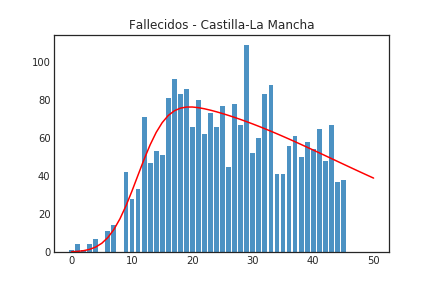
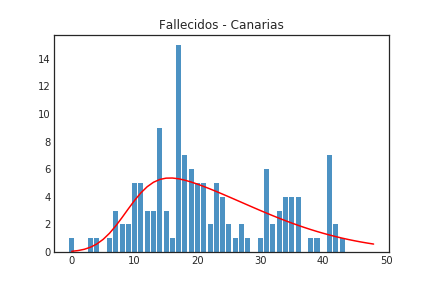
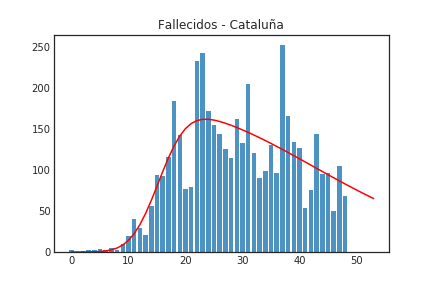
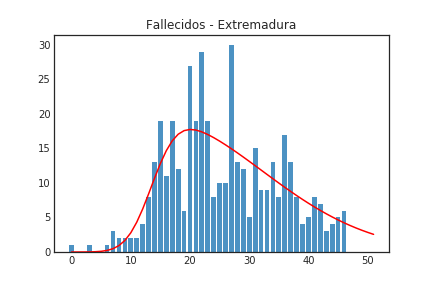
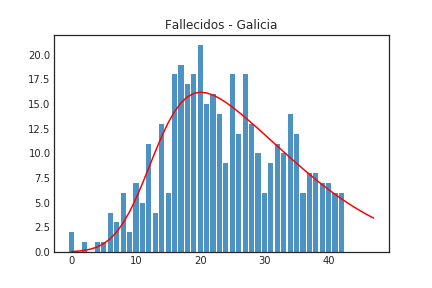
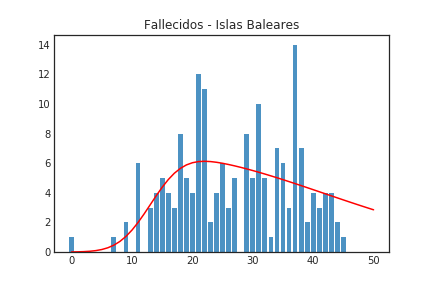
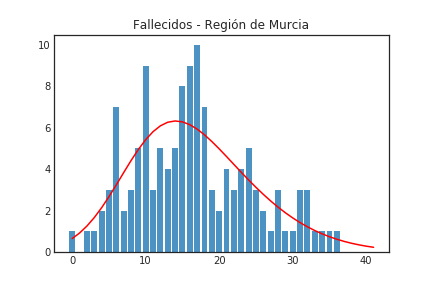
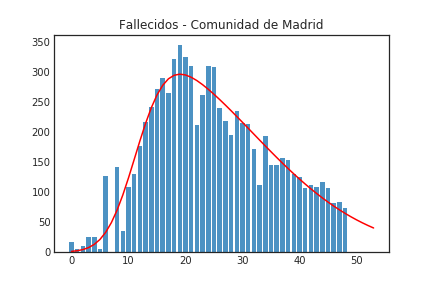
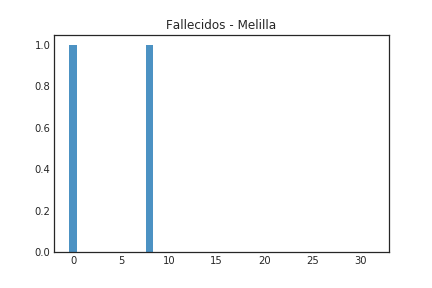
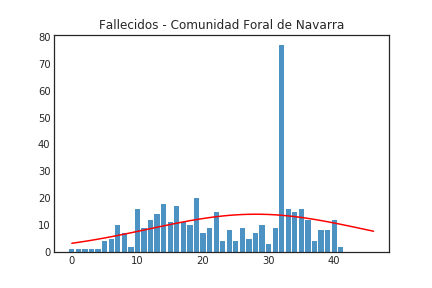
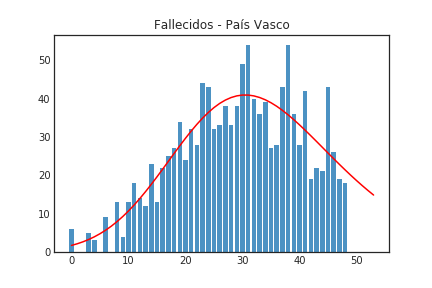
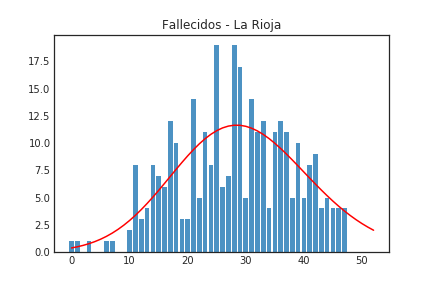
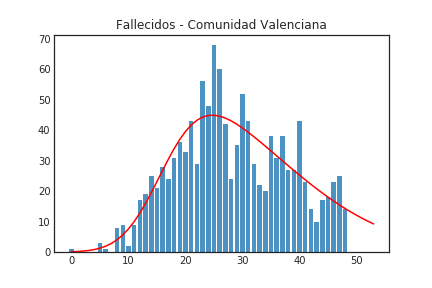

In [13]:
plotAll(df, 'Fallecidos', 'tab:blue', dif=True)


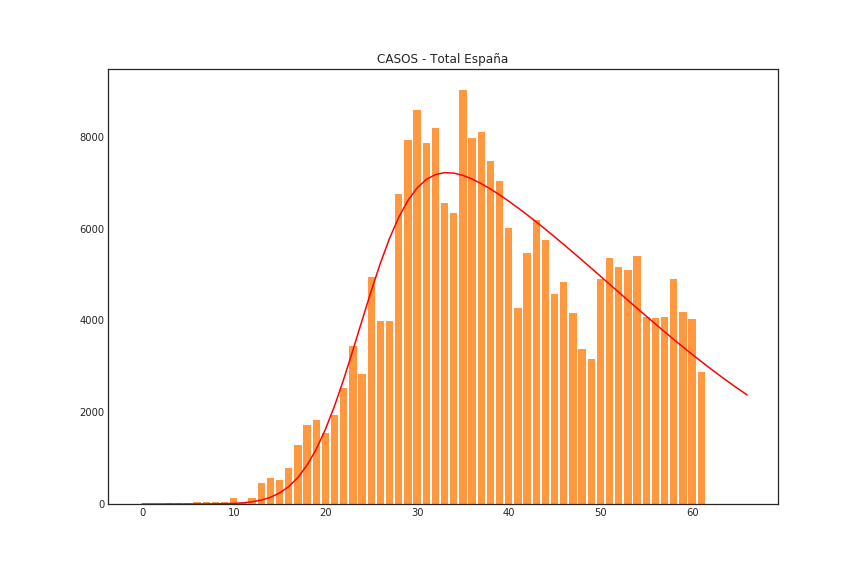
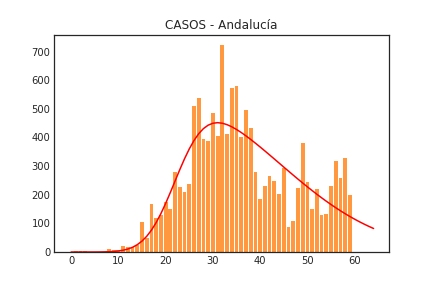
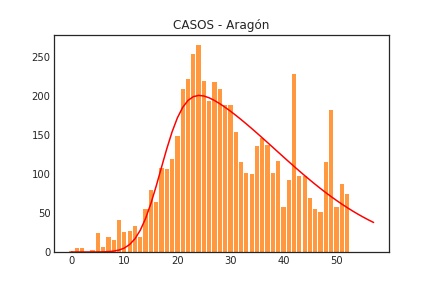
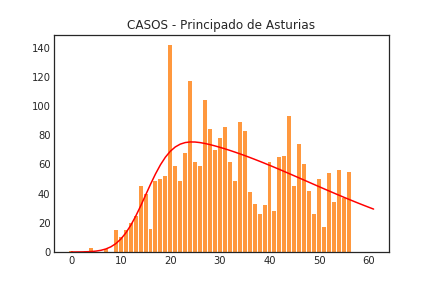
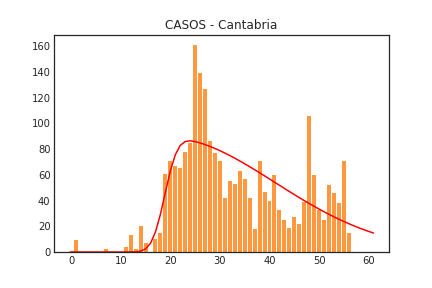
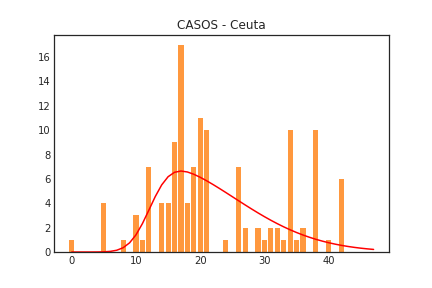
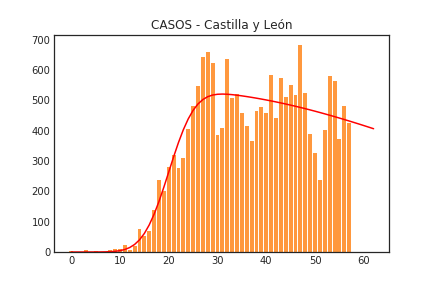
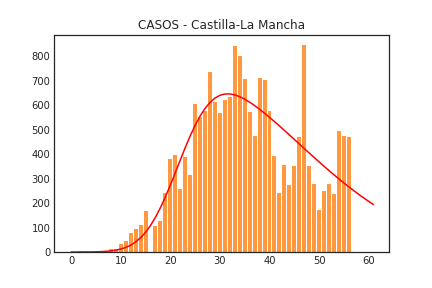
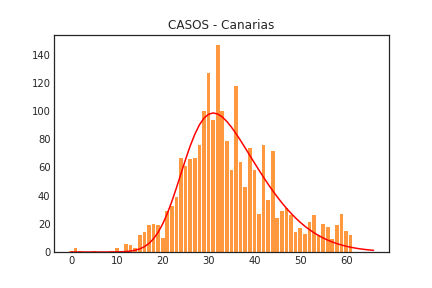
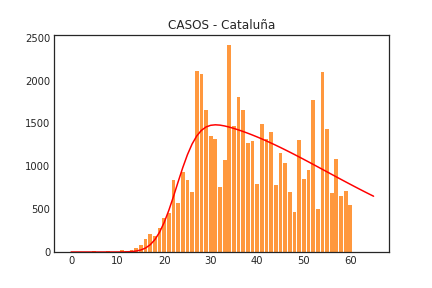
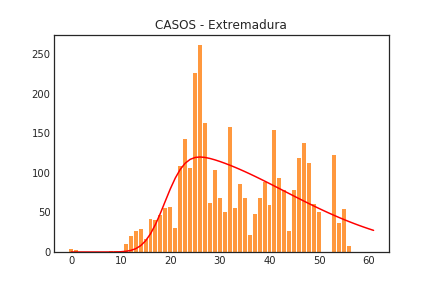
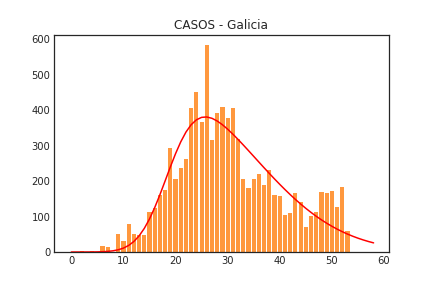
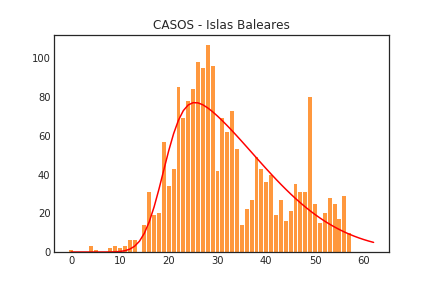
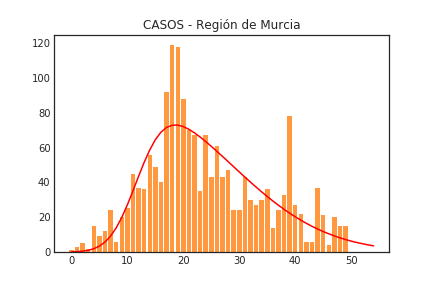
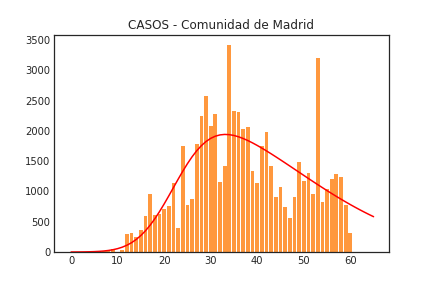
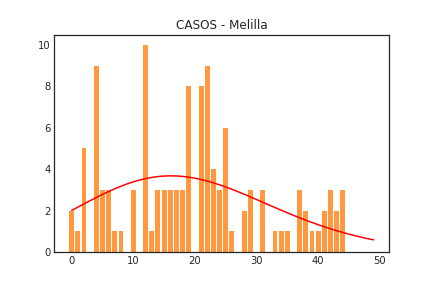
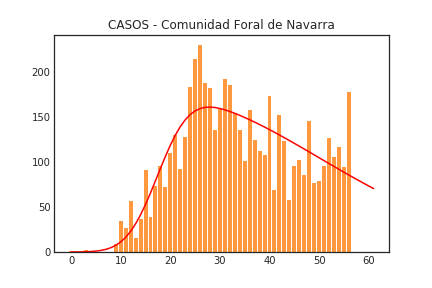
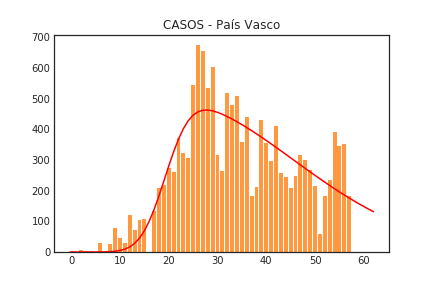
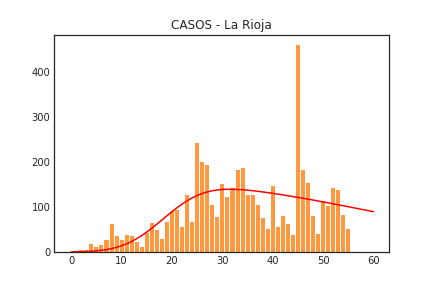
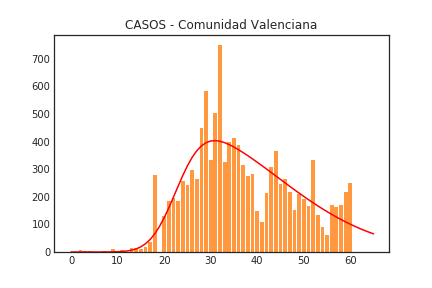

In [14]:
plotAll(df,'CASOS','tab:orange', dif=True)